In [1]:
# import needed packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from scipy import stats

# set up plot

sns.set(rc={'figure.figsize':(15,8)})

# import data
task = pd.read_csv('Risk Project/Risk_Project_Task.csv')
task.head(3)

,Date,Private equity,Private debt
0,31-03-1981,100.00,NaN
1,30-06-1981,101.37,NaN
2,30-09-1981,102.52,NaN


In [2]:
# change the date column into datetime

dates=task['Date']
dates2=pd.to_datetime(dates, infer_datetime_format=True)

In [3]:

task=task.drop('Date', axis=1)
task.insert(0, 'Date', dates2)
task.head(3)

,Date,Private equity,Private debt
0,1981-03-31,100.00,NaN
1,1981-06-30,101.37,NaN
2,1981-09-30,102.52,NaN


In [4]:
task.dtypes

Date              datetime64[ns]
Private equity           float64
Private debt             float64
dtype: object

In [5]:
task=task.set_index('Date')
task.head(3)

,Private equity,Private debt
Date,,
1981-03-31,100.00,NaN
1981-06-30,101.37,NaN
1981-09-30,102.52,NaN


In [6]:
# calculate private equity returns = ype

ppe=task['Private equity']
ype=np.diff(np.log(ppe), n=1, axis=0) 
ype=np.insert(ype, 0, 0.0)
task.insert(1,'Private equity returns', ype)
task.head(5)

,Private equity,Private equity returns,Private debt
Date,,,
1981-03-31,100.00,0.000000,NaN
1981-06-30,101.37,0.013607,NaN
1981-09-30,102.52,0.011281,NaN
1981-12-31,103.57,0.010190,NaN
1982-03-31,104.79,0.011711,NaN


In [7]:
# calculate private debt returns = ypd

ppd=task['Private debt']
ypd=np.diff(np.log(ppd), n=1, axis=0)
ypd=np.insert(ypd, 21, 0.0)
task.insert(3,'Private debt returns', ypd)
task.shape

(163, 4)

In [8]:
task.loc['30-09-1985':'30-09-1987']

,Private equity,Private equity returns,Private debt,Private debt returns
Date,,,,
1985-09-30,126.46,-0.001738,NaN,NaN
1985-12-31,129.80,0.026069,NaN,NaN
1986-03-31,129.79,-0.000077,NaN,NaN
1986-06-30,132.29,0.019079,99.16,0.000000
1986-09-30,132.20,-0.000681,97.86,-0.013197
1986-12-31,138.30,0.045109,98.34,0.004893
1987-03-31,145.24,0.048962,99.29,0.009614
1987-06-30,148.20,0.020175,100.51,0.012212
1987-09-30,151.09,0.019313,101.67,0.011475


In [9]:
T=len(ype)
T

163

In [10]:
# unsmooth the PE returns and calcuate TS characteristics and risk measures. 
# a=1.0 gives index returns, a=0.4 is baseline unsmoothing, while a=0.33 and a=0.5 are upper and lower unsmoothing limits
# p = VaR probability 


a=[1.0, 0.33, 0.4, 0.5]
p=0.05


ype1=np.insert(ype, 0, 0.0)
ype1 = np.delete(ype1,-1)

Tpe=len(ype)
op=ceil(T*p)

ype_st = np.zeros((Tpe,len(a)), dtype=float)
ype_sort = np.zeros(Tpe, dtype=float)
pe_stats = np.zeros((6,len(a)), dtype=float)

for i in range(len(a)):
    ype_st[:,i]=(ype-ype1*(1-a[i]))/a[i]
    pe_stats[0,i]=np.mean(ype_st[:,i])
    pe_stats[1,i]=np.std(ype_st[:,i], ddof=1)
    pe_stats[2,i]=stats.skew(ype_st[:,i])
    pe_stats[3,i]=stats.kurtosis(ype_st[:,i], fisher = False)
    
    ype_sort=np.sort(ype_st[:,i])
    VaR = -ype_sort[op-1]
    pe_stats[4,i]=VaR
    
    ES=-np.mean(ype_sort[:op])
    pe_stats[5,i]=ES
   
    
pe_stats


array([[ 0.03308569,  0.03370776,  0.03354528,  0.03339208],
       [ 0.05465932,  0.14807186,  0.12053681,  0.09561442],
       [ 0.48490811,  0.48517991,  0.52856349,  0.56928804],
       [10.01058952,  7.56861275,  8.26288075,  9.21077829],
       [ 0.0472049 ,  0.23741847,  0.18688894,  0.12719529],
       [ 0.09435327,  0.31306744,  0.25083421,  0.19215717]])

In [11]:
list = ['Mean','Volatility', 'Skewness', 'Kurtosis', 'VaR HS', 'ES HS']
pe_df=pd.DataFrame({'PE returns':list, 'a=1.0':pe_stats[:,0], 'a=0.33':pe_stats[:,1], 'a=0.4':pe_stats[:,2], 'a=0.5':pe_stats[:,3]})
pe_df = pe_df.set_index('PE returns')
pe_df

,a=1.0,a=0.33,a=0.4,a=0.5
PE returns,,,,
Mean,0.033086,0.033708,0.033545,0.033392
Volatility,0.054659,0.148072,0.120537,0.095614
Skewness,0.484908,0.485180,0.528563,0.569288
Kurtosis,10.010590,7.568613,8.262881,9.210778
VaR HS,0.047205,0.237418,0.186889,0.127195
ES HS,0.094353,0.313067,0.250834,0.192157


In [12]:
task.insert(2,'Unsmoothed PE low', ype_st[:,1])
task.insert(3,'Unsmoothed PE mid', ype_st[:,2])
task.insert(4,'Unsmoothed PE high', ype_st[:,3])
task.head(3)

,Private equity,Private equity returns,Unsmoothed PE low,Unsmoothed PE mid,Unsmoothed PE high,Private debt,Private debt returns
Date,,,,,,,
1981-03-31,100.00,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1981-06-30,101.37,0.013607,0.041233,0.034018,0.027214,NaN,NaN
1981-09-30,102.52,0.011281,0.006558,0.007791,0.008954,NaN,NaN


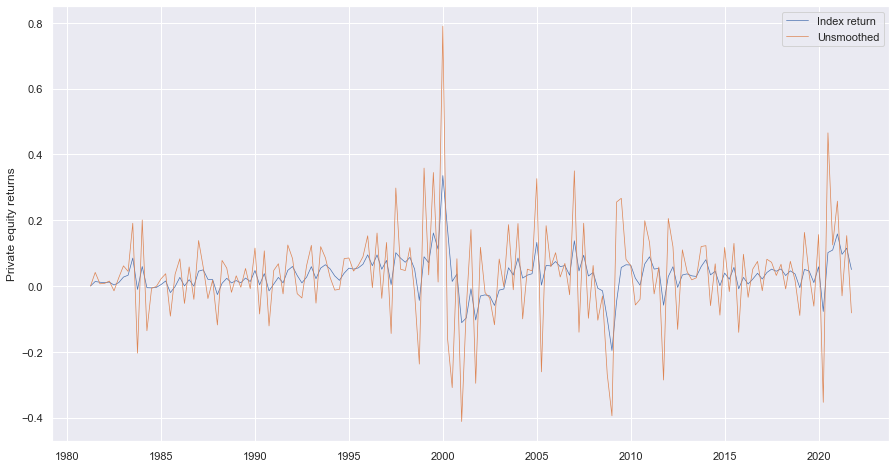

In [13]:

fig, ax = plt.subplots()
ax.plot(task['Private equity returns'],
linestyle='-', linewidth=0.7, label='Index return')
ax.plot(task['Unsmoothed PE low'],
linestyle='-', linewidth=0.7, label='Unsmoothed')
ax.set_ylabel('Private equity returns')

ax.legend();

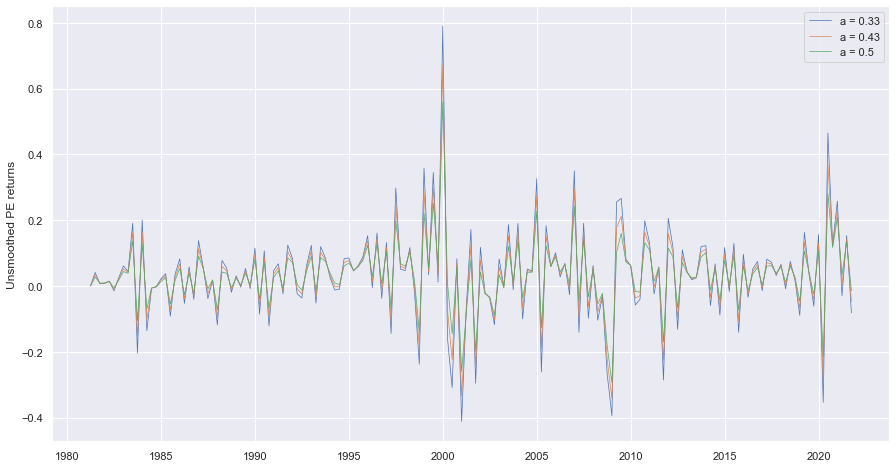

In [14]:
fig, ax = plt.subplots()
ax.plot(task['Unsmoothed PE low'],
linestyle='-', linewidth=0.7, label='a = 0.33')
ax.plot(task['Unsmoothed PE mid'],
linestyle='-', linewidth=0.7, label='a = 0.43')
ax.plot(task['Unsmoothed PE high'],
linestyle='-', linewidth=0.7, label='a = 0.5')
ax.set_ylabel('Unsmoothed PE returns')

ax.legend();

In [15]:
ypd = [x for x in ypd if not pd.isnull(x)]



ypd1=np.insert(ypd, 0, 0.0)
ypd1 = np.delete(ypd1,-1)

Tpd=len(ypd)
opd=ceil(T*p)

ypd_st = np.zeros((Tpd,len(a)), dtype=float)
ypd_sort = np.zeros(Tpd, dtype=float)
pd_stats = np.zeros((6,len(a)), dtype=float)

for i in range(len(a)):
    ypd_st[:,i]=(ypd-ypd1*(1-a[i]))/a[i]
    pd_stats[0,i]=np.mean(ypd_st[:,i])
    pd_stats[1,i]=np.std(ypd_st[:,i], ddof=1)
    pd_stats[2,i]=stats.skew(ypd_st[:,i])
    pd_stats[3,i]=stats.kurtosis(ypd_st[:,i], fisher = False)
    
    ypd_sort=np.sort(ypd_st[:,i])
    VaR = -ypd_sort[op-1]
    pd_stats[4,i]=VaR
    
    ES=-np.mean(ypd_sort[:op])
    pd_stats[5,i]=ES
   
    
pd_stats



array([[ 0.02506423,  0.02564534,  0.02549356,  0.02535045],
       [ 0.03813637,  0.11669444,  0.09416658,  0.07353524],
       [-1.47974029, -0.12460028, -0.3211322 , -0.60212209],
       [10.54847524,  6.41256598,  6.69664322,  7.28836134],
       [ 0.02770897,  0.14678973,  0.11909339,  0.0929797 ],
       [ 0.06970414,  0.25310009,  0.20343308,  0.15660418]])

In [16]:
list = ['Mean','Volatility', 'Skewness', 'Kurtosis', 'VaR', 'ES']
pd_df=pd.DataFrame({'PD returns':list, 'a=1.0':pd_stats[:,0], 'a=0.33':pd_stats[:,1], 'a=0.4':pd_stats[:,2], 'a=0.5':pd_stats[:,3]})
pd_df = pd_df.set_index('PD returns')
pd_df

,a=1.0,a=0.33,a=0.4,a=0.5
PD returns,,,,
Mean,0.025064,0.025645,0.025494,0.025350
Volatility,0.038136,0.116694,0.094167,0.073535
Skewness,-1.479740,-0.124600,-0.321132,-0.602122
Kurtosis,10.548475,6.412566,6.696643,7.288361
VaR,0.027709,0.146790,0.119093,0.092980
ES,0.069704,0.253100,0.203433,0.156604


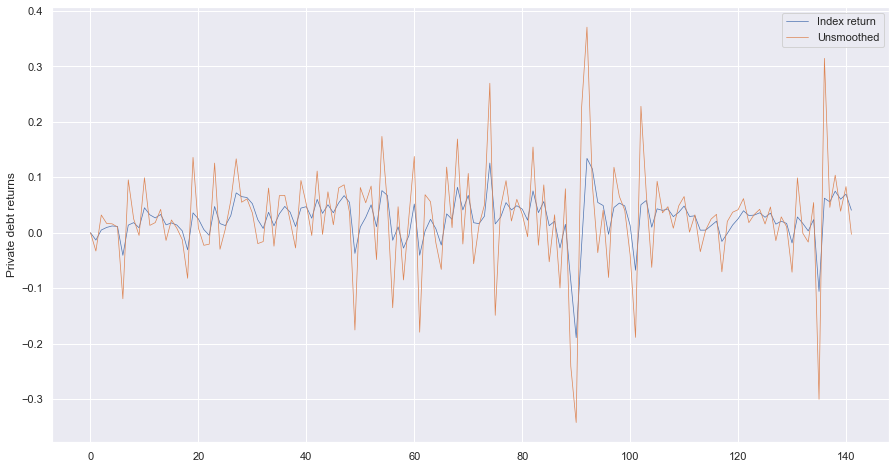

In [17]:

fig, ax = plt.subplots()
ax.plot(ypd_st[:,0],
linestyle='-', linewidth=0.7, label='Index return')
ax.plot(ypd_st[:,2],
linestyle='-', linewidth=0.7, label='Unsmoothed')
ax.set_ylabel('Private debt returns')

ax.legend();

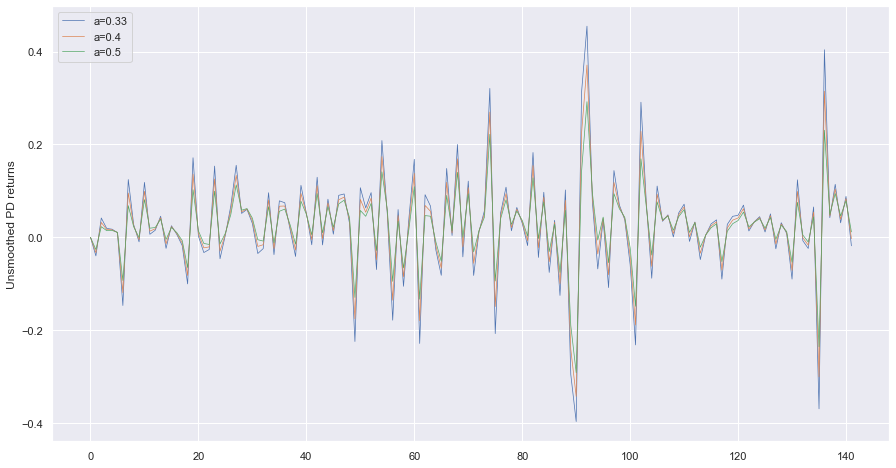

In [18]:
fig, ax = plt.subplots()
ax.plot(ypd_st[:,1],
linestyle='-', linewidth=0.7, label='a=0.33')
ax.plot(ypd_st[:,2],
linestyle='-', linewidth=0.7, label='a=0.4')
ax.plot(ypd_st[:,3],
linestyle='-', linewidth=0.7, label='a=0.5')
ax.set_ylabel('Unsmoothed PD returns')

ax.legend();

In [19]:
# upsampling. linearly interpolate prices


ppeup=ppe.resample('m').interpolate()
dfup=ppeup.to_frame()
dfup.head(3)

,Private equity
Date,
1981-03-31,100.000000
1981-04-30,100.456667
1981-05-31,100.913333


In [20]:
# calculate upsampled returns

ypeup=np.diff(np.log(ppeup), n=1, axis=0) 
ypeup=np.insert(ypeup, 0, 0.0)
dfup.insert(1,'Private equity returns', ypeup)
dfup.head(3)

,Private equity,Private equity returns
Date,,
1981-03-31,100.000000,0.000000
1981-04-30,100.456667,0.004556
1981-05-31,100.913333,0.004536


In [21]:
info = pd.read_csv('Risk Project/Risk_Project_Info.csv')

dates3=info['Date']
dates4=pd.to_datetime(dates3, infer_datetime_format=True)

info=info.drop('Date', axis=1)
info.insert(0, 'Date', dates4)

info.head(7)

,Date,MSCI PRICE,MSCI TOTAL RETURN,MSCI TOTAL RETURN.1,gold,LEV LOANS INDEX,CORPORATE BONDS TR,REITs GLOBAL TR,Fama French Market,Fama French Size,Fama French Value,Fama French Robust,Fama French Conservative,Risk free
0,1989-12-31,379.41,762.584,1205.700,401.00,NaN,NaN,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,1990-01-31,353.94,713.133,1149.589,412.75,NaN,NaN,NaN,92.150000,98.680000,100.850000,98.820000,101.370000,100.570000
2,1990-02-28,358.50,723.758,1100.482,407.50,NaN,NaN,NaN,93.172865,99.814820,101.495440,98.750826,100.751643,101.143249
3,1990-03-30,368.00,740.920,1034.213,369.50,NaN,NaN,NaN,94.877928,101.391894,98.531773,100.745593,99.794502,101.790566
4,1990-04-30,358.81,725.864,1019.493,367.75,NaN,NaN,NaN,91.690030,101.067440,95.979800,102.569088,98.796557,102.492921
5,1990-05-31,393.80,793.009,1127.042,363.75,NaN,NaN,NaN,99.410331,98.672142,92.303774,104.148652,97.235572,103.189873
6,1990-06-29,391.14,790.122,1119.200,352.75,NaN,NaN,NaN,98.326758,99.964747,90.522311,103.003017,96.885524,103.839969


In [24]:
nowdf=pd.merge(dfup, info, on = "Date", how = "inner")
nowdf=nowdf.set_index('Date')
nowdf.head(3)

,Private equity,Private equity returns,MSCI PRICE,MSCI TOTAL RETURN,MSCI TOTAL RETURN.1,gold,LEV LOANS INDEX,CORPORATE BONDS TR,REITs GLOBAL TR,Fama French Market,Fama French Size,Fama French Value,Fama French Robust,Fama French Conservative,Risk free
Date,,,,,,,,,,,,,,,
1989-12-31,171.190000,0.015423,379.41,762.584,1205.700,401.00,NaN,NaN,NaN,100.000000,100.00000,100.00000,100.000000,100.000000,100.000000
1990-01-31,171.383333,0.001129,353.94,713.133,1149.589,412.75,NaN,NaN,NaN,92.150000,98.68000,100.85000,98.820000,101.370000,100.570000
1990-02-28,171.576667,0.001127,358.50,723.758,1100.482,407.50,NaN,NaN,NaN,93.172865,99.81482,101.49544,98.750826,100.751643,101.143249


In [25]:
nowdf.to_csv('Risk Project/nowdf.csv')